In [1]:
%load_ext autoreload
%autoreload 2

# Plotly Plasma
In this notebook we demonstrate the use of the Plotly Plasma library to circunvent many of the shortcomings of the standard Plotly library. 

In [2]:
import pandas as pd
from plasma import plasma
import plotly.express as px
import plotly.io as pio
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.renderers.default = "svg"
pio.templates.default = "plotly_white"


Lets first generate a dataset to work with

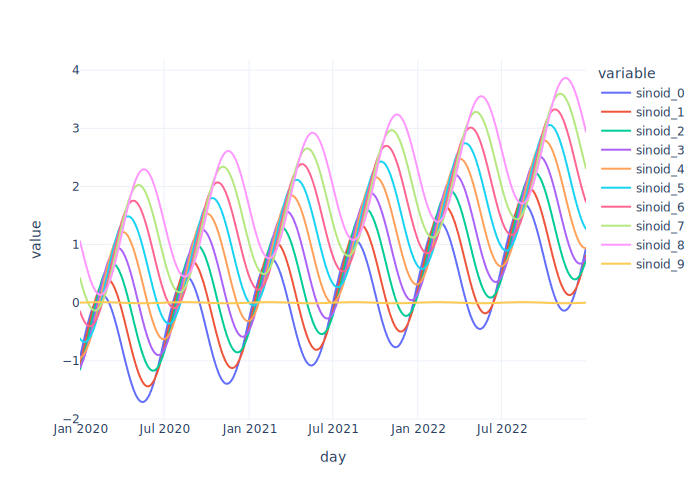

In [124]:
df_index = pd.date_range("2020-01-01", "2022-12-31", freq="D", name="day")
n_samples = df_index.shape[0]
x_array = np.linspace(-np.pi * 6, np.pi * 6, n_samples)
noise = np.random.random(df_index.shape[0])


def sinoid(x_lag, y_multiplier, linear_coefficient):
    return np.sin(x_array - x_lag) * y_multiplier + linear_coefficient


y_arrays = [
    sinoid(x_lag, y_multiplier, linear_coefficient) + x_array/20
    for x_lag, y_multiplier, linear_coefficient in zip(
        np.linspace(0, np.pi, 9), [1] * 9, np.linspace(0, 2, 9)
    )
]
y_arrays.append(sinoid(0, 0.01, 0))
data = pd.DataFrame(y_arrays).T.set_index(df_index)
data.columns = [f"sinoid_{i}" for i in range(10)]

px.line(data)


# Multiple y-axis
When the values of the metrics are in very different scales, plotly doesnt have an easy way to do dual axis.

The default function will use the largest axis, and the variance of the small axis will be barely noticeable.

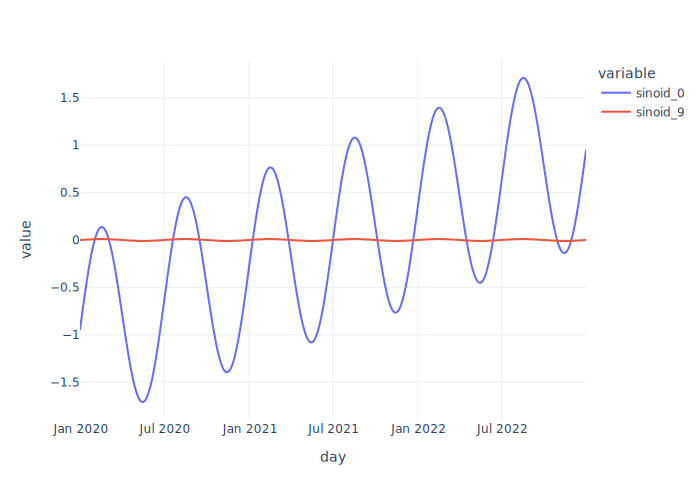

In [107]:
px.line(data[["sinoid_0", "sinoid_9"]])


## Dual axis with plotly

The workaround is to use subplots with `secondary_y`

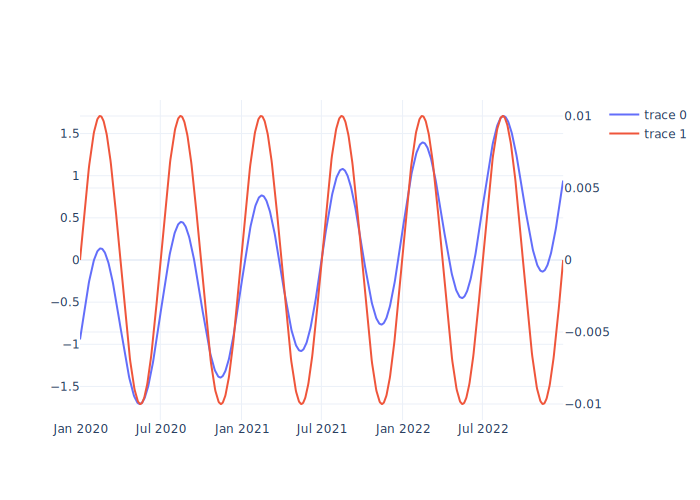

In [108]:
subplot_figure = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

subplot_figure = subplot_figure.add_trace(
    go.Scatter(x=data.index, y=data.sinoid_0), secondary_y=False
)

subplot_figure = subplot_figure.add_trace(
    go.Scatter(x=data.index, y=data.sinoid_9), secondary_y=True
)
subplot_figure


## Dual Axis with Plasma

`plasma` wraps that around the `dual_axis` method

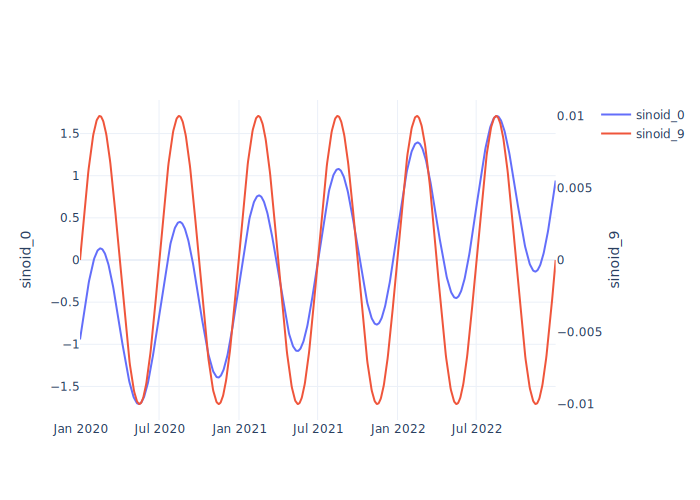

In [109]:
plasma.dual_axis_line(data, left_axis="sinoid_0", right_axis="sinoid_9")


# Markers
Labels in Plotly can be very awkward

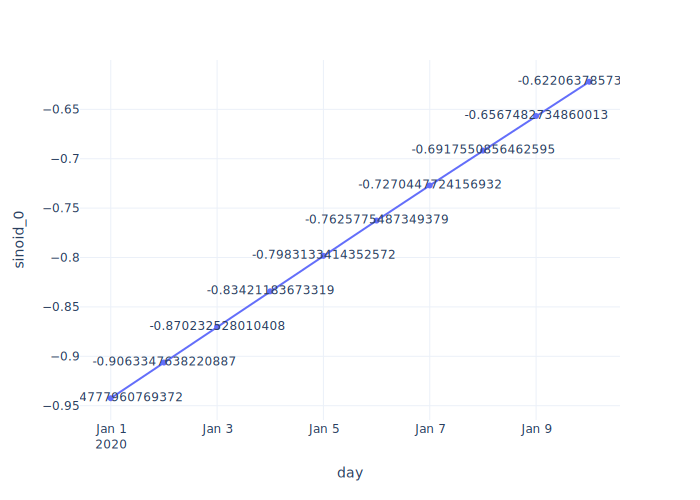

In [110]:
fig = px.line(
    data.loc[:"2020-01-10"],
    y="sinoid_0",
    text="sinoid_0",
)
fig


## Plotly markers text
The default solution is somewhat clumsy.

The argument names are not very intuitive, and the `tickformat` format string does not follow the same format as `texttemplate`

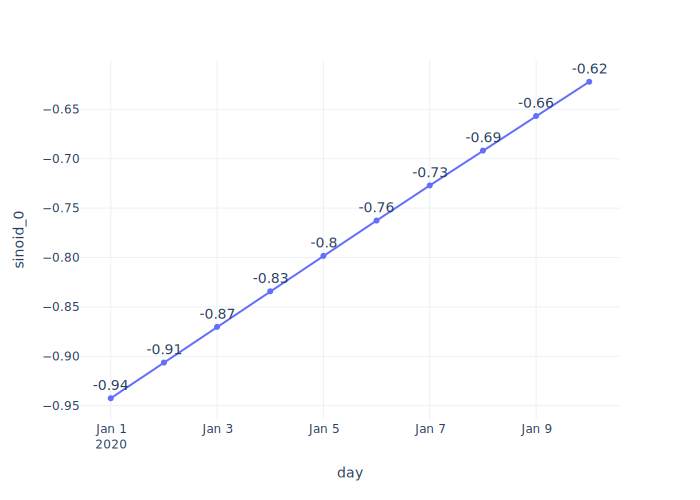

In [111]:
fig.update_traces(
    texttemplate="%{text:.2}",
    textfont=go.scatter.Textfont(size=14),  # could also be just {"size": 14},
    textposition="top center",
).update_yaxes(tickformat=".2f")


# Markers text with Plasma
`plasma` will round floating numbers to one decimal by default.

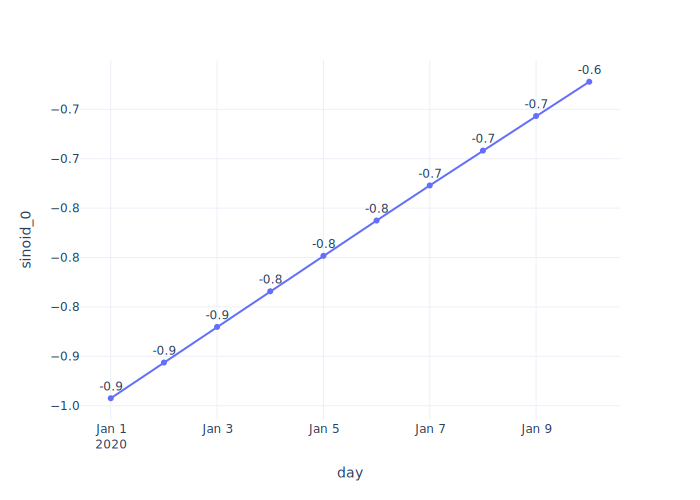

In [112]:
plasma.fix_marker_text(fig)


You can also use python standard format strings for markers and tick format

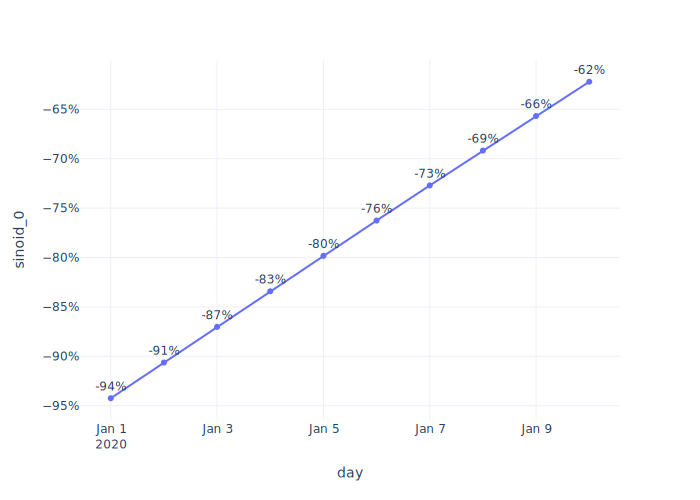

In [113]:
plasma.fix_marker_text(fig, marker_format="{:.0%}", tick_format="{:.0%}")


To keep using the fluent syntax, you can use `plasma.fluent` to add the `fix_marker_text` method to the Figure class.

In [93]:
plasma.fluent()


fix_marker_text and continuous_lines are now available on go.Figure


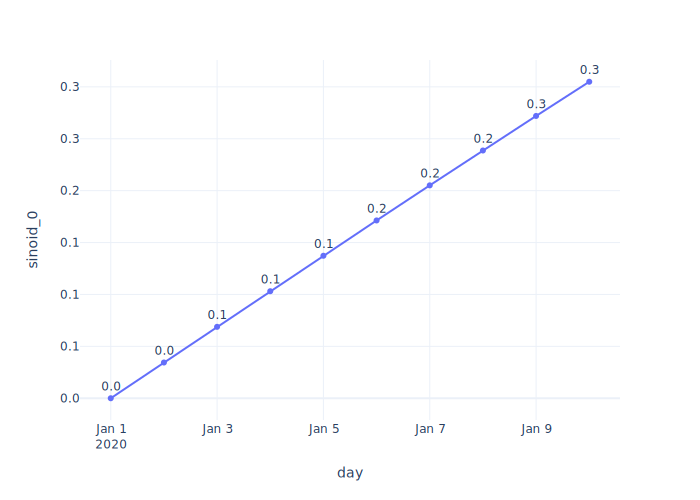

In [96]:
px.line(
    data.loc[:"2020-01-10"],
    y="sinoid_0",
    text="sinoid_0",
).fix_marker_text()


# Year-over-year comparisons
Lets try to overlay the data from different years

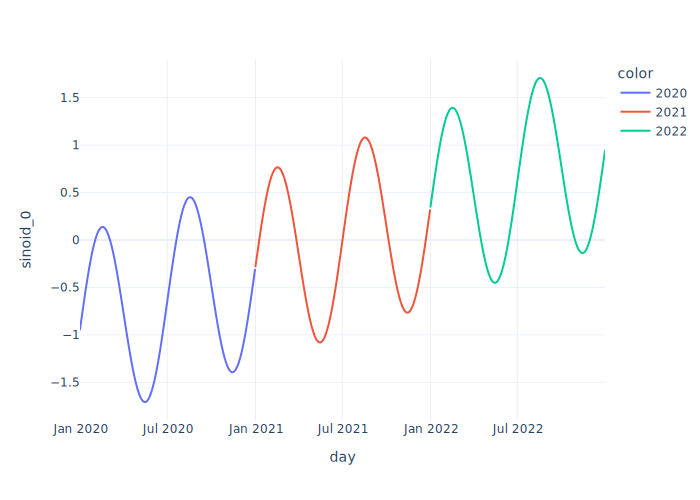

In [126]:
px.line(data, y="sinoid_0", color=data.index.year)


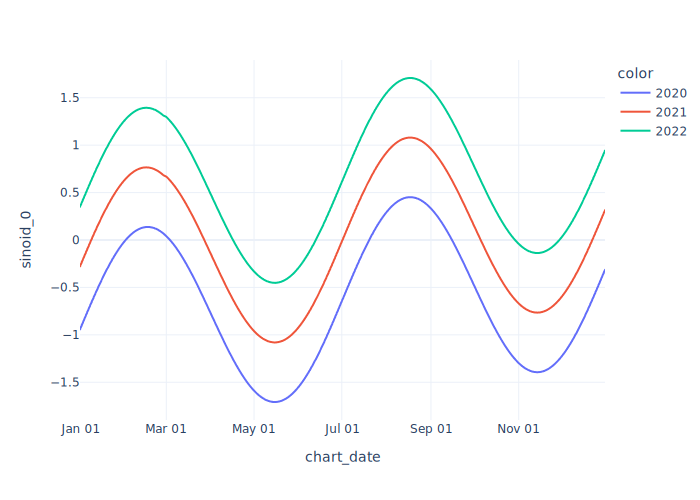

In [129]:
overlayed = data.assign(chart_date=lambda df: df.index.strftime("2020-%m-%d"))
px.line(overlayed, x="chart_date", y="sinoid_0", color=data.index.year).update_xaxes(
    tickformat="%b %d"
)



You can use `plasma.overlay_yoy` to achieve the same effect, but passing a DataFrame instead, as long as the date is the index.

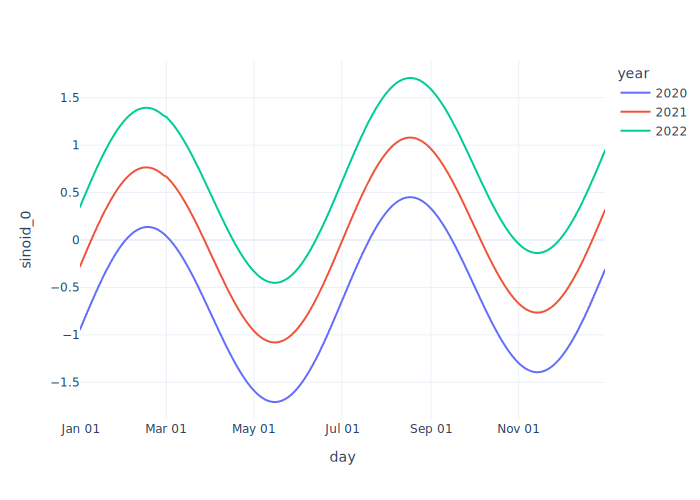

In [131]:
data.pipe(plasma.overlay_yoy, "sinoid_0")


# Multiple lines as continuous color
When you have multiple lines, plotly has no easy way to color them by a continuous variable, only discrete.

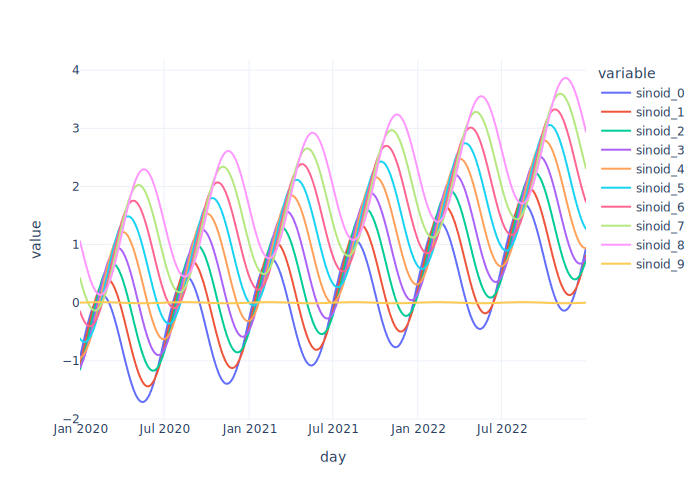

In [132]:
fig = px.line(data)
fig

The workaround is to change manually the color attribute of the traces.

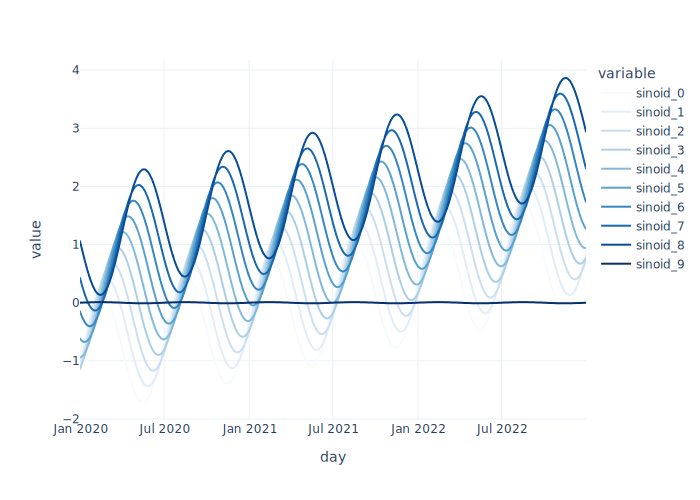

In [133]:
n_colors = 10
colors = px.colors.sample_colorscale("Blues", n_colors)
for index, color in enumerate(colors):
    fig.data[index]["line"]["color"] = color
fig


Thats wrapped in `plasma.continuous_color`

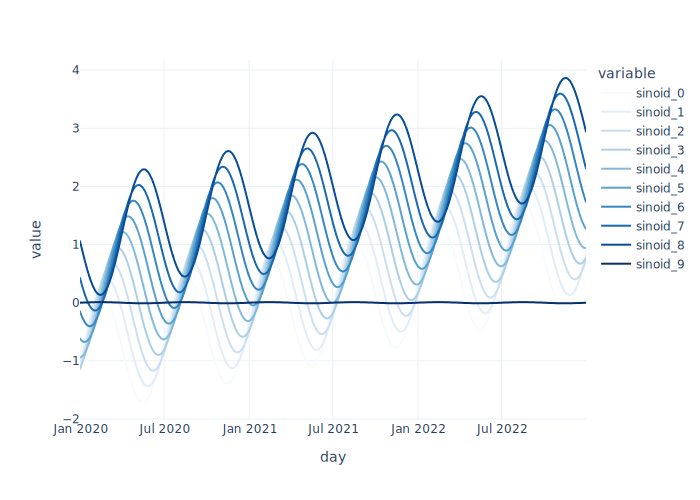

In [139]:
px.line(data).continuous_color(colorscale="Blues")


# Facets